In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from itertools import product
import warnings
from scipy import stats


In [2]:
tabl=np.load('may2016.npy') #Загружаем данные 

In [3]:
data=tabl[tabl.sum(axis=1).argmax()] #Берём данные из ячейки с максимальным суммарным количеством поездок

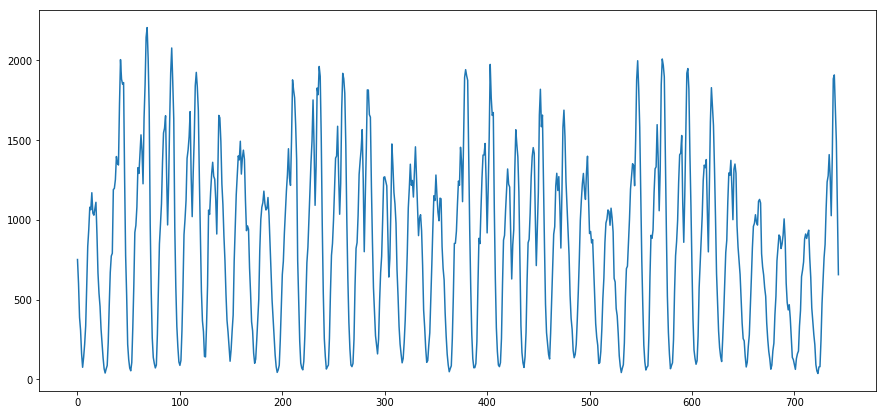

In [4]:
plt.figure(figsize=(15,7))
plt.plot(data)
plt.show()      #отрисуем поездки

Критерий Дики-Фуллера: p=0.030543


<Figure size 1080x504 with 0 Axes>

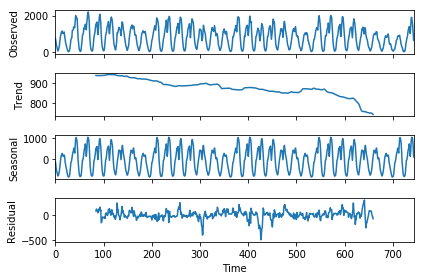

In [5]:
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(data,freq=168).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data)[1])

Тест Дики Фулера отвернает гипотезу о нестационарности, но на графиках виден тренд, необходимо сделать обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

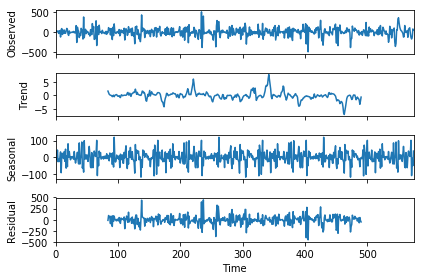

In [6]:
data_dif1 = data[168:]-data[:-168]
data_dif2=data_dif1[1:]-data_dif1[:-1]
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data_dif2,freq=168).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_dif2)[1])

Гипотеза о нестационарности отвергается, тренда более менее нет

Посмотрим на ACF и PACF полученного ряда:

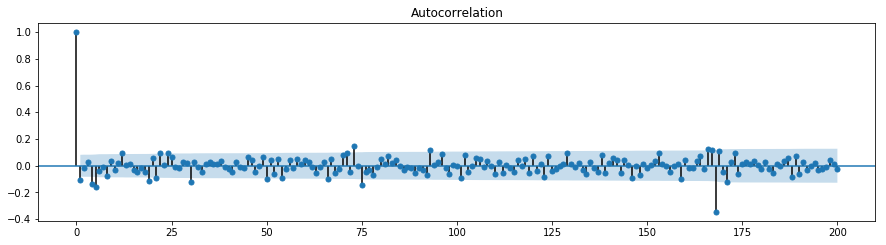

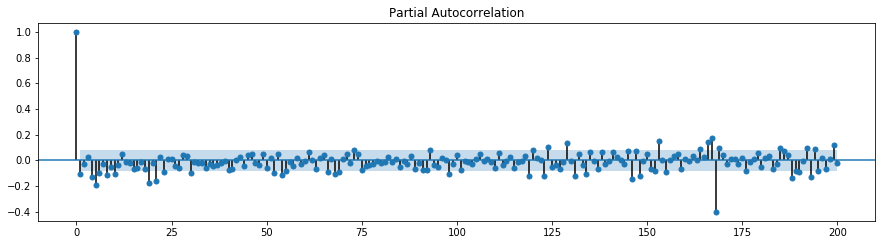

In [7]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_dif2, lags=200, ax=ax)
plt.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_dif2, lags=200, ax=ax)
plt.show()

Начальные приближения: Q=0, q=1, P=1, p=2

In [8]:
ps = range(0, 3)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = 0

In [9]:
parameters = product(ps, qs, Ps)
parameters_list = list(parameters)
len(parameters_list)

12

Создаём регрессионные признаки

In [71]:
K=3
exog=np.zeros((744,2))
for i in range(168*K):
    exog[i][0]=np.sin(2.*np.pi*i/168.)
    exog[i][1]=np.cos(2.*np.pi*i/168.)


Поиск лучшей модели

In [72]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data, exog=exog, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, 0, 12)).fit(disp=-1)
        # Для сезонного пытался ставить 168 - но чем больше параметр, тем дольше работает программа или зависает
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0))
('wrong parameters:', (2, 1, 1))
Wall time: 18.4 s


In [73]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters          aic
3  (0, 1, 1)  9181.223369
5  (1, 0, 1)  9186.439690
9  (2, 0, 1)  9188.406869
7  (1, 1, 1)  9201.111684
1  (0, 0, 1)  9213.124431


Рисуем исходные данные и модельные

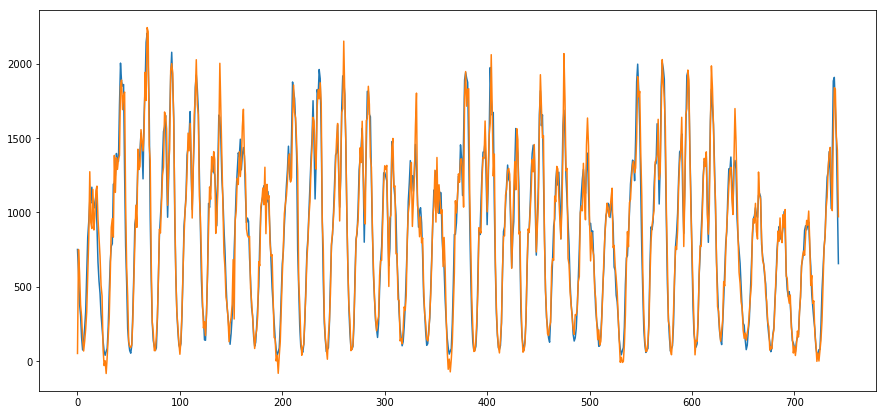

In [74]:
plt.figure(figsize=(15,7))
plt.plot(data)
plt.plot(best_model.fittedvalues)
plt.show()

Анализ остатков

Критерий Стьюдента: p=0.980979
Критерий Дики-Фуллера: p=0.000000


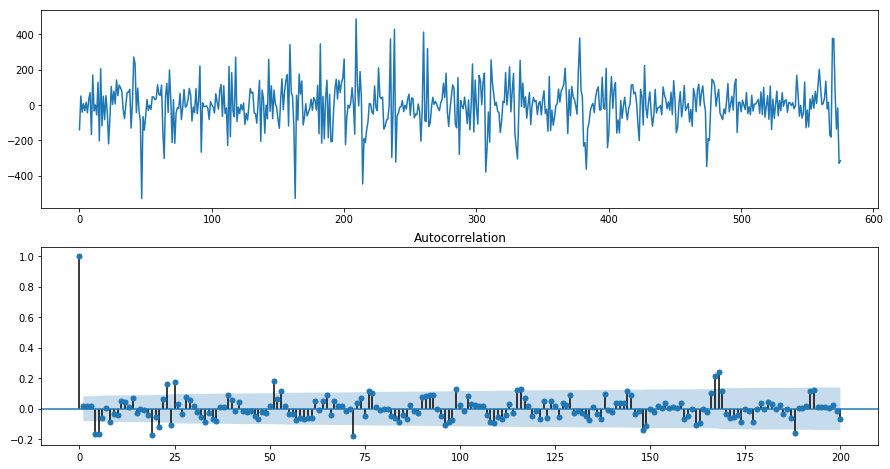

In [75]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(best_model.resid[168:])

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[168:].squeeze(), lags=200, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[168:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[168:])[1])

Особых выводов сделать не могу. Попытки менять параметры модели не дают заметных результатов. Параметр exog практически не влияет на результаты.